In [1]:
import gym
import numpy as np
np.random.seed(1)

In [2]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import RMSprop
from keras.initializers import TruncatedNormal

Using TensorFlow backend.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
env = gym.make('FrozenLake-v0')
env.seed(1)


[2017-05-21 05:56:06,224] Making new env: FrozenLake-v0


[1]

In [5]:
class QNetwork():
    
    def __init__(self):
        
        self.n_features = 16
        self.n_actions = 4
        self.lr = 0.01
        self.gamma = 0.99
        self.epsilon = 0.10
        self.model = self._build_net()
            
    def _build_net(self):
        l_input = Input(batch_shape=(None, self.n_features))
        q = Dense(4, activation='linear', kernel_initializer=TruncatedNormal(mean=0, stddev=0.1))(l_input)
        model = Model(inputs=l_input, outputs=q)
        model.compile(loss='mse', optimizer='sgd')
        return model
    
    def learn(self, s, a, r, s_, done):
        
        s = self.one_hot(s, self.n_features)
        s_ = self.one_hot(s_, self.n_features)
        
        q = self.model.predict(s)
        
        target = r
        if not done:
            target = r + self.gamma*np.amax(self.model.predict(s_))
                    
        q[0, a] = target
        self.model.fit(s, q, verbose=False)
        
    
    def choice_action(self, state):
        state = self.one_hot(state, self.n_features)
        act = np.argmax(self.model.predict(state))
        
        if np.random.rand() < self.epsilon:
            act = env.action_space.sample()
            
        return act
    
    def one_hot(self, ix, n):
        vec = np.zeros(n)
        vec[ix] = 1
        return vec.reshape(1,n)



In [6]:
qnet = QNetwork()

In [7]:
MAX_EPISODE = 2000
track_r = []

for i_episode in range(MAX_EPISODE):

    t = 0
    ep_r = 0

    state = env.reset()

    while True:

        act = qnet.choice_action(state)
        next_state, reward, done, info = env.step(act)

        if (done and reward != 1): reward = -0.88    
        ep_r += reward
        qnet.learn(state, act, reward, next_state, done)

        t += 1

        if done:

            track_r.append(ep_r)

            if i_episode % 50 == 0:
                print("episode:", i_episode, " steps", t, " reward:", ep_r)

            break
        
        state = next_state


episode: 0  steps 13  reward: -0.88
episode: 50  steps 23  reward: -0.88
episode: 100  steps 29  reward: -0.88
episode: 150  steps 9  reward: -0.88
episode: 200  steps 11  reward: -0.88
episode: 250  steps 13  reward: 1.0
episode: 300  steps 29  reward: -0.88
episode: 350  steps 24  reward: 1.0
episode: 400  steps 22  reward: -0.88
episode: 450  steps 13  reward: 1.0
episode: 500  steps 20  reward: -0.88
episode: 550  steps 6  reward: 1.0
episode: 600  steps 14  reward: -0.88
episode: 650  steps 23  reward: -0.88
episode: 700  steps 20  reward: -0.88
episode: 750  steps 17  reward: -0.88
episode: 800  steps 22  reward: -0.88
episode: 850  steps 57  reward: -0.88
episode: 900  steps 56  reward: 1.0
episode: 950  steps 16  reward: 1.0
episode: 1000  steps 12  reward: -0.88
episode: 1050  steps 40  reward: 1.0
episode: 1100  steps 15  reward: -0.88
episode: 1150  steps 17  reward: -0.88
episode: 1200  steps 17  reward: -0.88
episode: 1250  steps 23  reward: -0.88
episode: 1300  steps 6  r

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=500,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


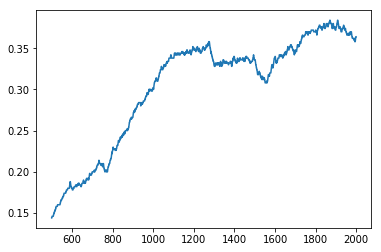

In [8]:
track_r = pd.Series(track_r)
track_r[track_r < 0] = 0
plt.plot(pd.rolling_mean(track_r, window=500))
